### XGBoost – Fold-Based Evaluation with Separate Train and Test Sets

* **Dataset:** Wind turbine power generation data divided into 8 temporal folds using a sliding window approach.
* **Per Fold Workflow:**

  * Use a specified **percentage of the training set** (e.g., 10%, 20%, 70%, 100%) for training the model.
  * Always evaluate on the **separate, fixed test set** associated with each fold.
* **XGBoost Model:**

  * Hyperparameters (`n_estimators`, `learning_rate`, `max_depth`, etc.) tuned via `GridSearchCV`.
  * No feature scaling is required due to the tree-based nature of XGBoost.

This evaluation procedure allows a **consistent and fair comparison** with other methods (including semi-supervised ones like S2RMS), by measuring how well the model performs **with limited labeled data**, while keeping the **data splits and evaluation process identical across models**.


In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score
from scipy.io import arff

sns.set_theme(style="whitegrid")

In [2]:
DATA_DIR = "../data/swdpf/arff_scaled_folds"
RESULTS_DIR = "../results/xgboost_folds"
os.makedirs(RESULTS_DIR, exist_ok=True)

SCALES = [100]
FOLDS = range(8)
TARGET_COL = "patv_target_1"
SEED = 42

In [3]:
def evaluate_xgboost_on_fold(train_df, test_df, scale, fold):
    scale_ratio = scale / 100

    # Shuffle il train set per riproducibilità
    train_df = train_df.sample(frac=1.0, random_state=SEED+fold).reset_index(drop=True)
    n_train = len(train_df)
    n_labeled = int(n_train * scale_ratio)

    labeled = train_df.iloc[:n_labeled]

    X_train = labeled.drop(columns=[TARGET_COL])
    y_train = labeled[TARGET_COL]

    X_test = test_df.drop(columns=[TARGET_COL])
    y_test = test_df[TARGET_COL]

    model = XGBRegressor(objective='reg:squarederror', random_state=fold)

    param_grid = {
        'n_estimators': [100, 200],
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 6],
        'subsample': [0.8],
        'colsample_bytree': [0.8]
    }

    grid_search = GridSearchCV(
        model,
        param_grid=param_grid,
        scoring='neg_mean_absolute_error',
        cv=5,
        n_jobs=-1,
        verbose=0
    )
    grid_search.fit(X_train, y_train)
    y_pred = grid_search.predict(X_test)

    scaler_y_path = os.path.join(DATA_DIR, f"scaler_y_fold{fold}.joblib")
    scaler_y = joblib.load(scaler_y_path)

    y_test_denorm = scaler_y.inverse_transform(y_test.values.reshape(-1, 1)).ravel()
    y_pred_denorm = scaler_y.inverse_transform(y_pred.reshape(-1, 1)).ravel()

    rmse = root_mean_squared_error(y_test_denorm, y_pred_denorm)
    mae = mean_absolute_error(y_test_denorm, y_pred_denorm)
    rse = np.sum((y_test_denorm - y_pred_denorm) ** 2) / np.sum((y_test_denorm - np.mean(y_test_denorm)) ** 2)
    r2 = r2_score(y_test_denorm, y_pred_denorm)

    return {
        "fold": fold,
        "scale": scale,
        "rmse": rmse,
        "mae": mae,
        "rse": rse,
        "r2": r2,
        "n_labeled": n_labeled,
        "n_train": n_train,
        "n_test": len(test_df),
        "best_params": grid_search.best_params_
    }

In [4]:
results = []

for fold in FOLDS:
    train_arff_path = os.path.join(DATA_DIR, f"fold{fold}_train.arff")
    test_arff_path = os.path.join(DATA_DIR, f"fold{fold}_test.arff")

    train_data, _ = arff.loadarff(train_arff_path)
    train_df = pd.DataFrame(train_data)

    test_data, _ = arff.loadarff(test_arff_path)
    test_df = pd.DataFrame(test_data)

    for scale in SCALES:
        print(f"Fold {fold} | Scale {scale}%")
        metrics = evaluate_xgboost_on_fold(train_df, test_df, scale, fold)
        results.append(metrics)

Fold 0 | Scale 100%
Fold 1 | Scale 100%
Fold 2 | Scale 100%
Fold 3 | Scale 100%
Fold 4 | Scale 100%
Fold 5 | Scale 100%
Fold 6 | Scale 100%
Fold 7 | Scale 100%


In [5]:
results_df = pd.DataFrame(results)
results_df.to_csv(os.path.join(RESULTS_DIR, "xgboost_fold_results.csv"), index=False)

print("Results saved to:", os.path.join(RESULTS_DIR, "xgboost_fold_results.csv"))
display(results_df)

Results saved to: ../results/xgboost_folds\xgboost_fold_results.csv


,fold,scale,rmse,mae,rse,r2,n_labeled,n_train,n_test,best_params
0,0,100,189.700962,126.091496,0.166290,0.833710,23040,23040,10080,"{'colsample_bytree': 0.8, 'learning_rate': 0.1..."
1,1,100,110.849569,67.352293,0.132852,0.867148,23040,23040,10080,"{'colsample_bytree': 0.8, 'learning_rate': 0.1..."
2,2,100,73.857554,31.246357,0.073771,0.926229,23040,23040,10080,"{'colsample_bytree': 0.8, 'learning_rate': 0.1..."
3,3,100,142.899163,95.703533,0.081770,0.918230,23040,23040,10080,"{'colsample_bytree': 0.8, 'learning_rate': 0.1..."
4,4,100,147.469456,123.152938,0.113253,0.886747,23040,23040,10080,"{'colsample_bytree': 0.8, 'learning_rate': 0.1..."
5,5,100,182.643692,103.515933,0.216442,0.783558,23040,23040,10080,"{'colsample_bytree': 0.8, 'learning_rate': 0.1..."
6,6,100,199.101309,145.164129,0.210556,0.789444,23040,23040,10080,"{'colsample_bytree': 0.8, 'learning_rate': 0.1..."
7,7,100,173.170905,121.998183,0.222844,0.777156,23040,23040,10080,"{'colsample_bytree': 0.8, 'learning_rate': 0.1..."


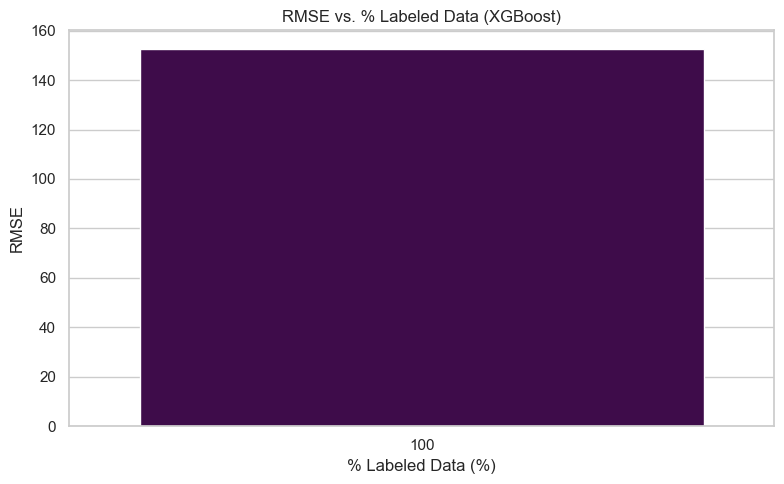

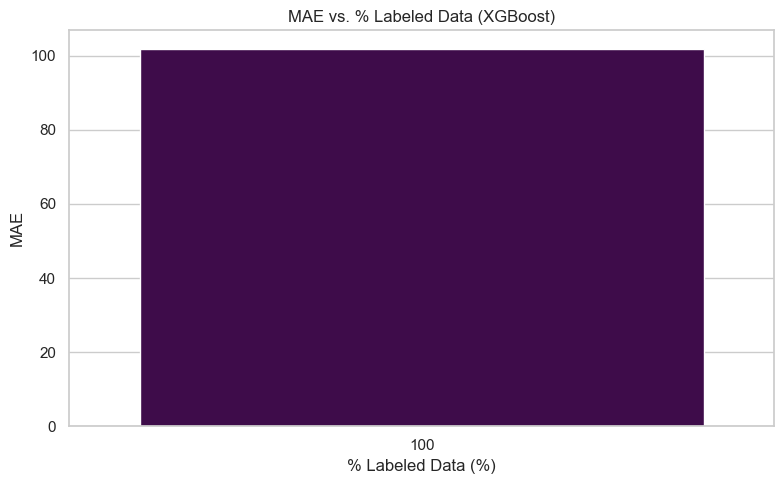

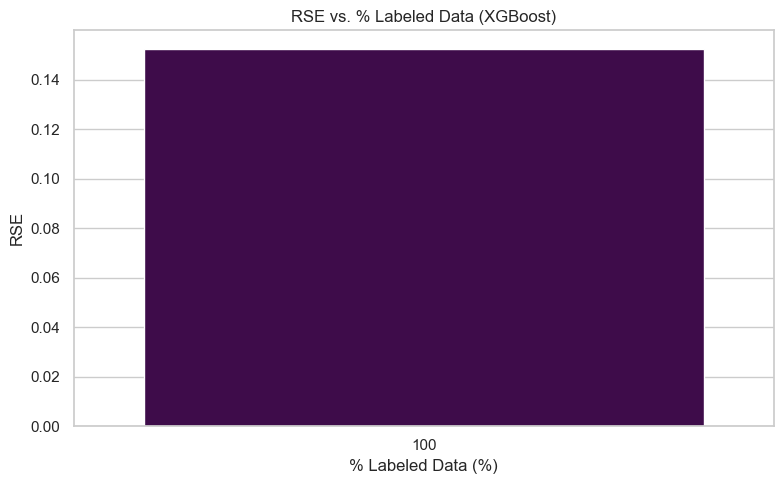

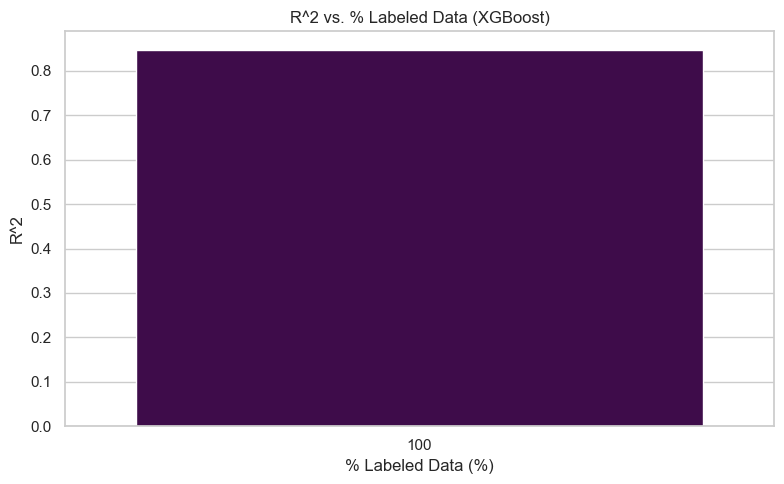

In [6]:
summary_df = results_df.groupby("scale").agg(
    rmse_mean=("rmse", "mean"),
    rmse_std=("rmse", "std"),
    mae_mean=("mae", "mean"),
    mae_std=("mae", "std"),
    rse_mean=("rse", "mean"),
    rse_std=("rse", "std"),
    r2_mean=("r2", "mean"),
    r2_std=("r2", "std")
).reset_index()

def plot_metric(df, metric, ylabel):
    plt.figure(figsize=(8, 5))
    sns.barplot(
        x="scale",
        y=f"{metric}_mean",
        hue="scale",
        data=df,
        palette="viridis",
        legend=False
    )
    plt.ylabel(ylabel)
    plt.title(f"{ylabel} vs. % Labeled Data (XGBoost)")
    plt.xlabel("% Labeled Data (%)")
    plt.tight_layout()
    plt.show()

plot_metric(summary_df, "rmse", "RMSE")
plot_metric(summary_df, "mae", "MAE")
plot_metric(summary_df, "rse", "RSE")
plot_metric(summary_df, "r2", "R^2")